In [ ]:
import gc
import math
import optuna
import numpy as np 
from imblearn.over_sampling import SMOTE
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split ,StratifiedKFold, cross_val_score, cross_validate
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline 
from catboost import CatBoostClassifier
from sklearn.metrics import  ConfusionMatrixDisplay, PrecisionRecallDisplay, accuracy_score, confusion_matrix, classification_report, average_precision_score, recall_score, f1_score, precision_recall_curve, auc


In [2]:
df = pd.read_csv("creditcard.csv")

<Axes: >

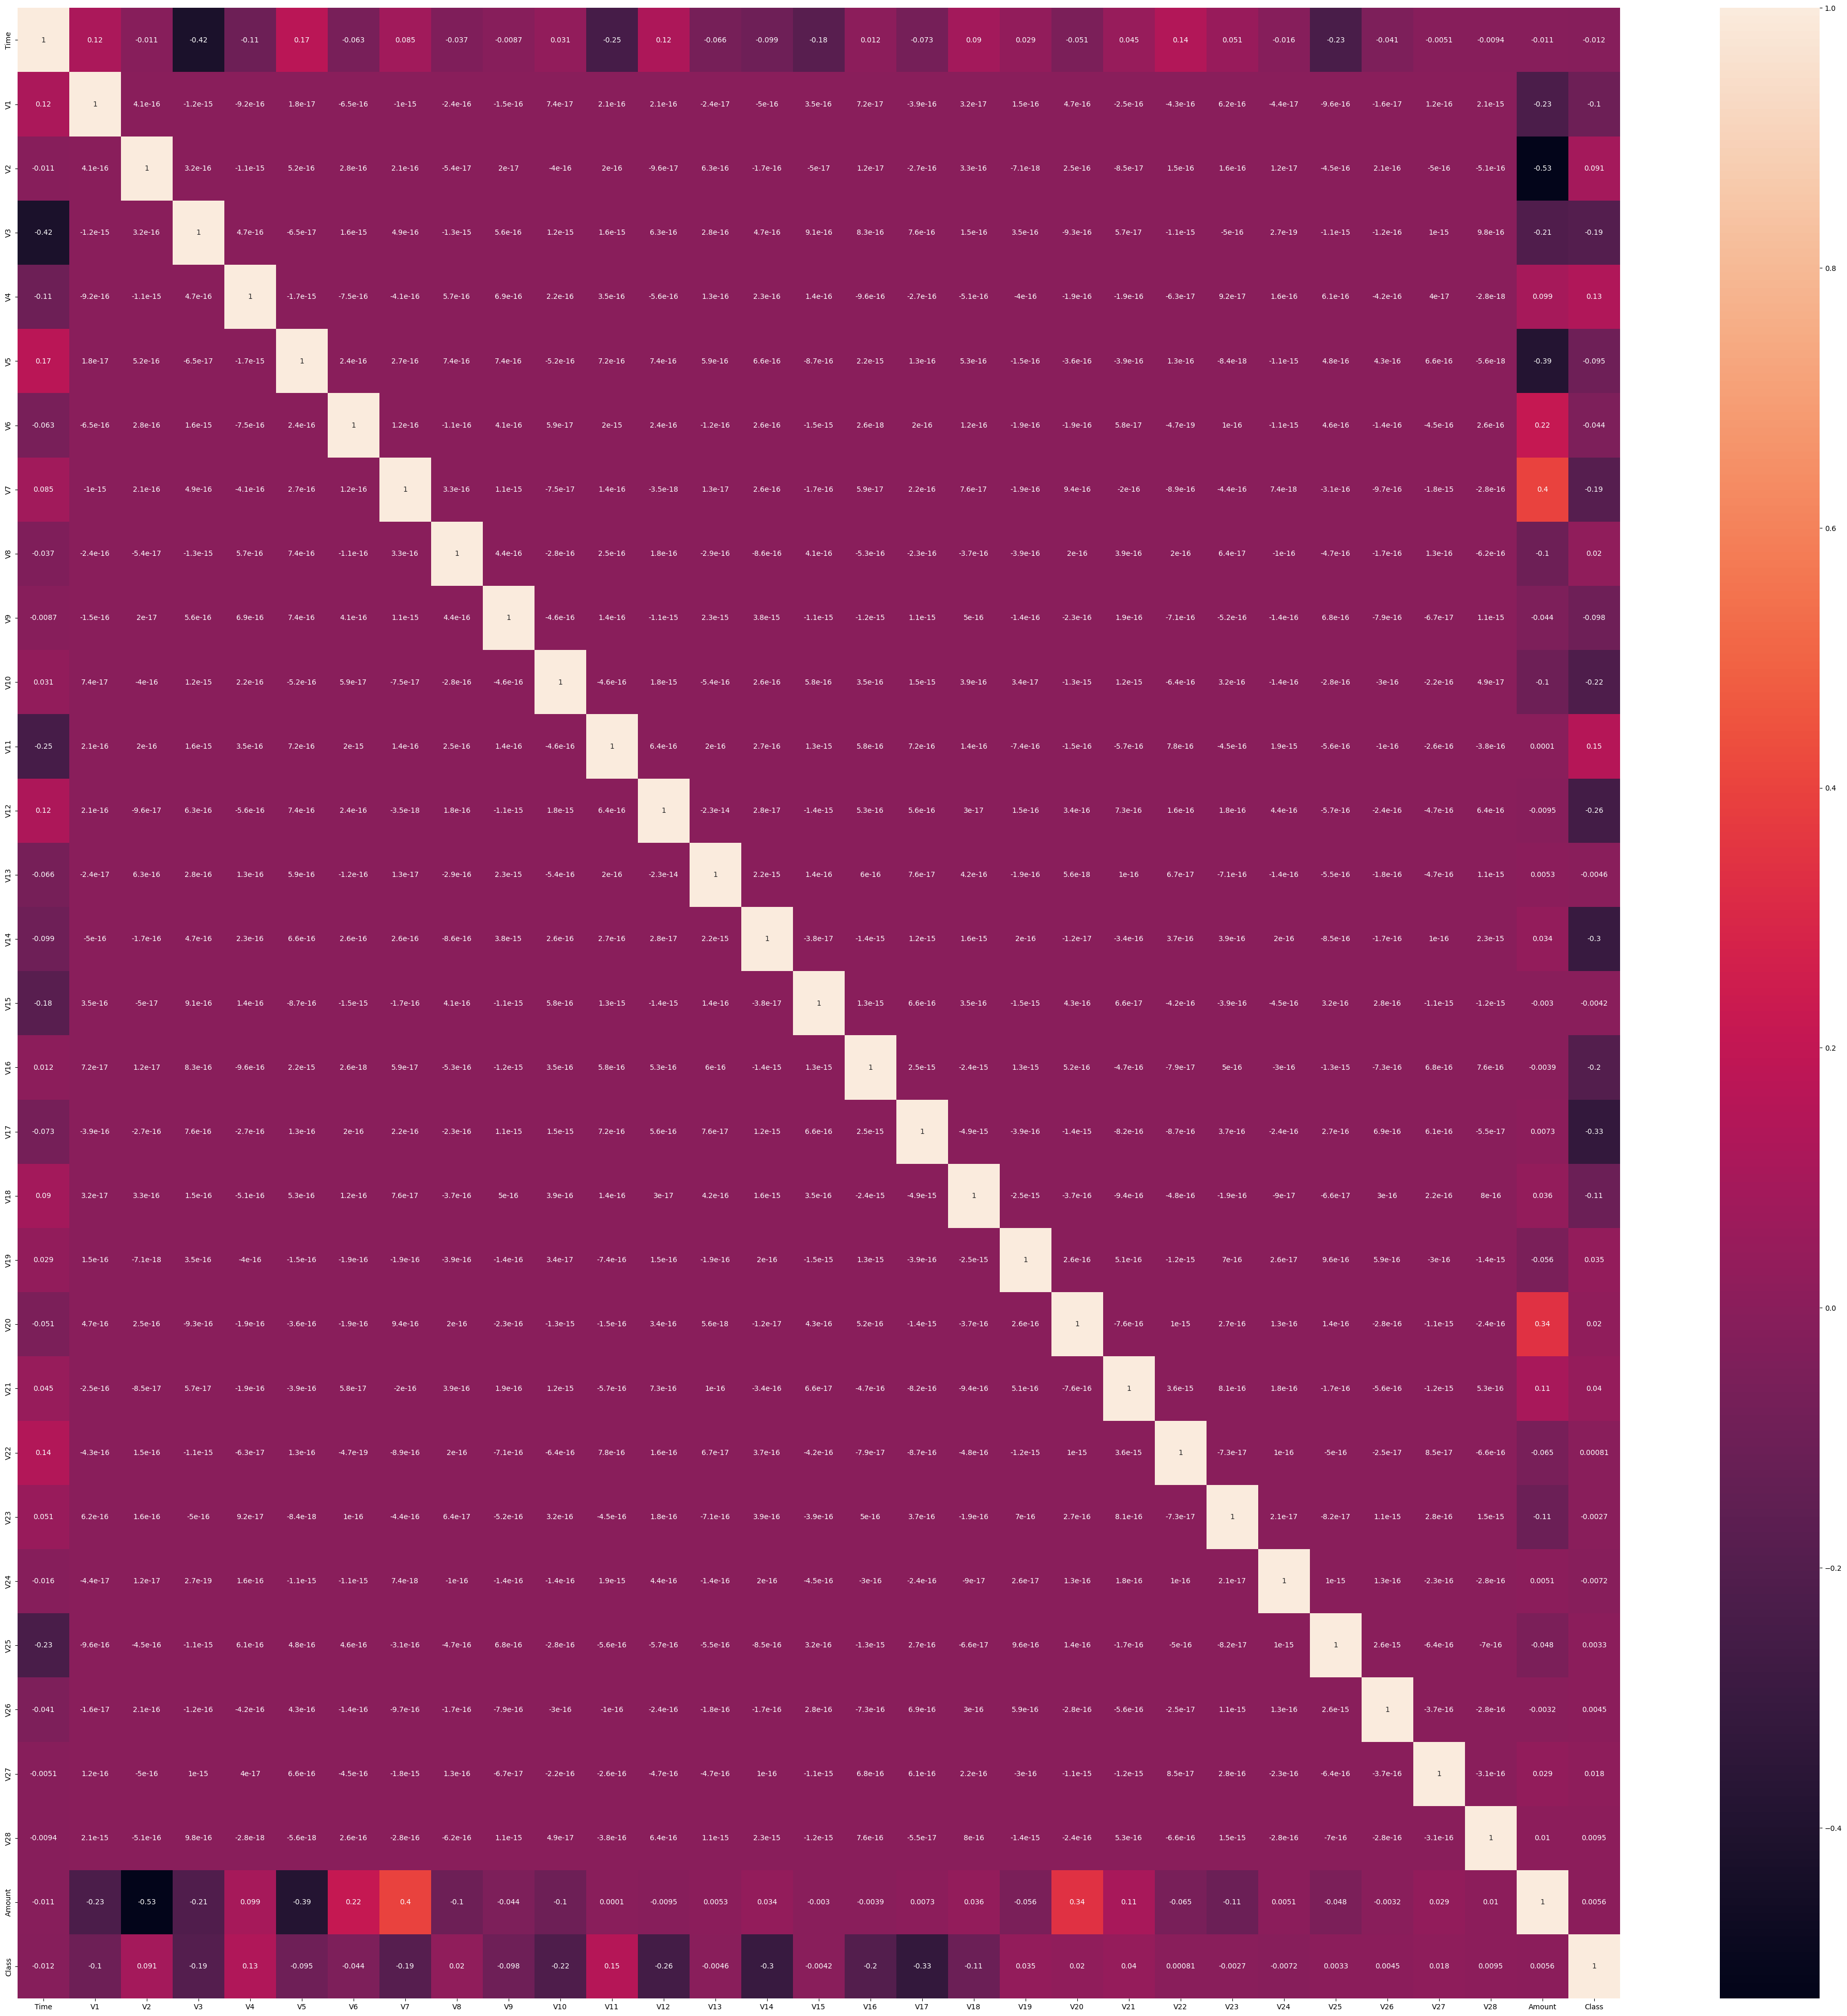

In [3]:
plt.figure(figsize =(50,50))
sns.heatmap(df.corr(), annot = True)

Korelasyon matrisi, özellikle V değişkenleri arasında çok da kayda değer bir ilişki olmadığını söylüyor. Bunun sebebi, bu değişkenlerin PCA metodu ile, orijinal verinin varyans açıklayıcılık seviyelerine göre üretilmiş veriler olmasıdır. Bir çok sürun olduğu için, orijinal verinin varyansını 100% açıklayacak şekilde bu değişikenler üretilmiştir.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Verisetimizde hiç
 null değer bulunmamaktadır.

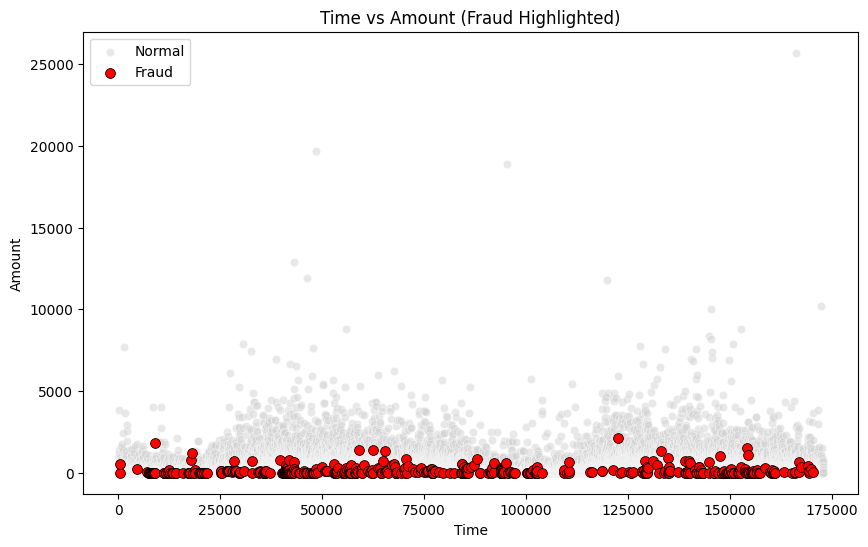

In [ ]:
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=df[df['Class'] == 0], 
    x="Time", y="Amount", 
    color="lightgray", alpha=0.5, label="Normal"
)

sns.scatterplot(
    data=df[df['Class'] == 1], 
    x="Time", y="Amount", 
    color="red", alpha=1, s=50, label="Fraud", edgecolor="black"
)

plt.title("Time vs Amount (Fraud Highlighted)")
plt.show()

İki farklı sınıfı tek grafikte göstermeye çalıştığımız için Fraud sınıfı çok ezilmiş gibi gözükse de, gerçek konumlarındadırlar.

In [24]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


Verisetimizin yaklaşık 0.17%'si fraud verilerden oluşmaktadır ve bu çok dengesiz bir verisetine sahip olduğumuzu gösterir.

In [8]:
columns = df.columns.unique()
columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

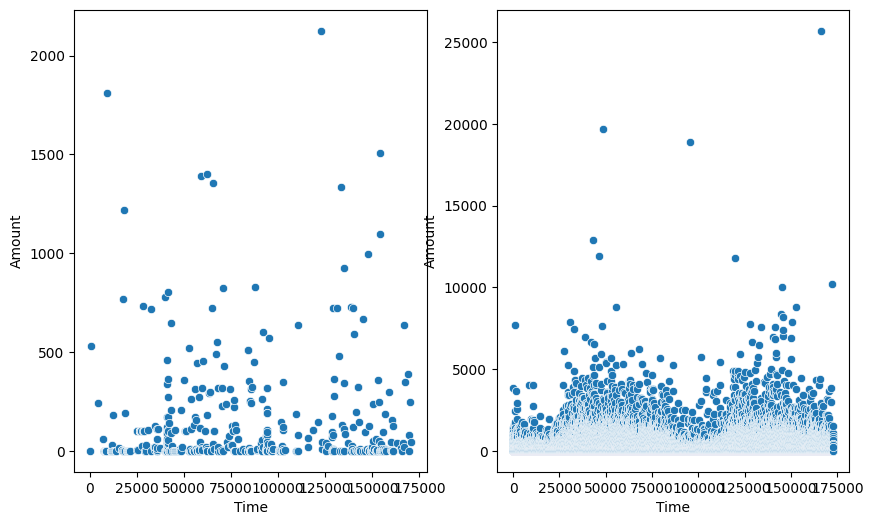

In [9]:
frauds = df[df['Class'] == 1]
non_frauds = df[df['Class'] == 0]


plt.figure(figsize = (10, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data = frauds, x = 'Time', y = 'Amount')

plt.subplot(1, 2, 2)
sns.scatterplot(data = non_frauds, x = 'Time', y = 'Amount')
plt.show()

İki farklı grafik karşılaştırılınca, aslında çok da büyük bir boyutsal fark görünmüyor. 3 boyutlu grafikte  gösterilebilir.

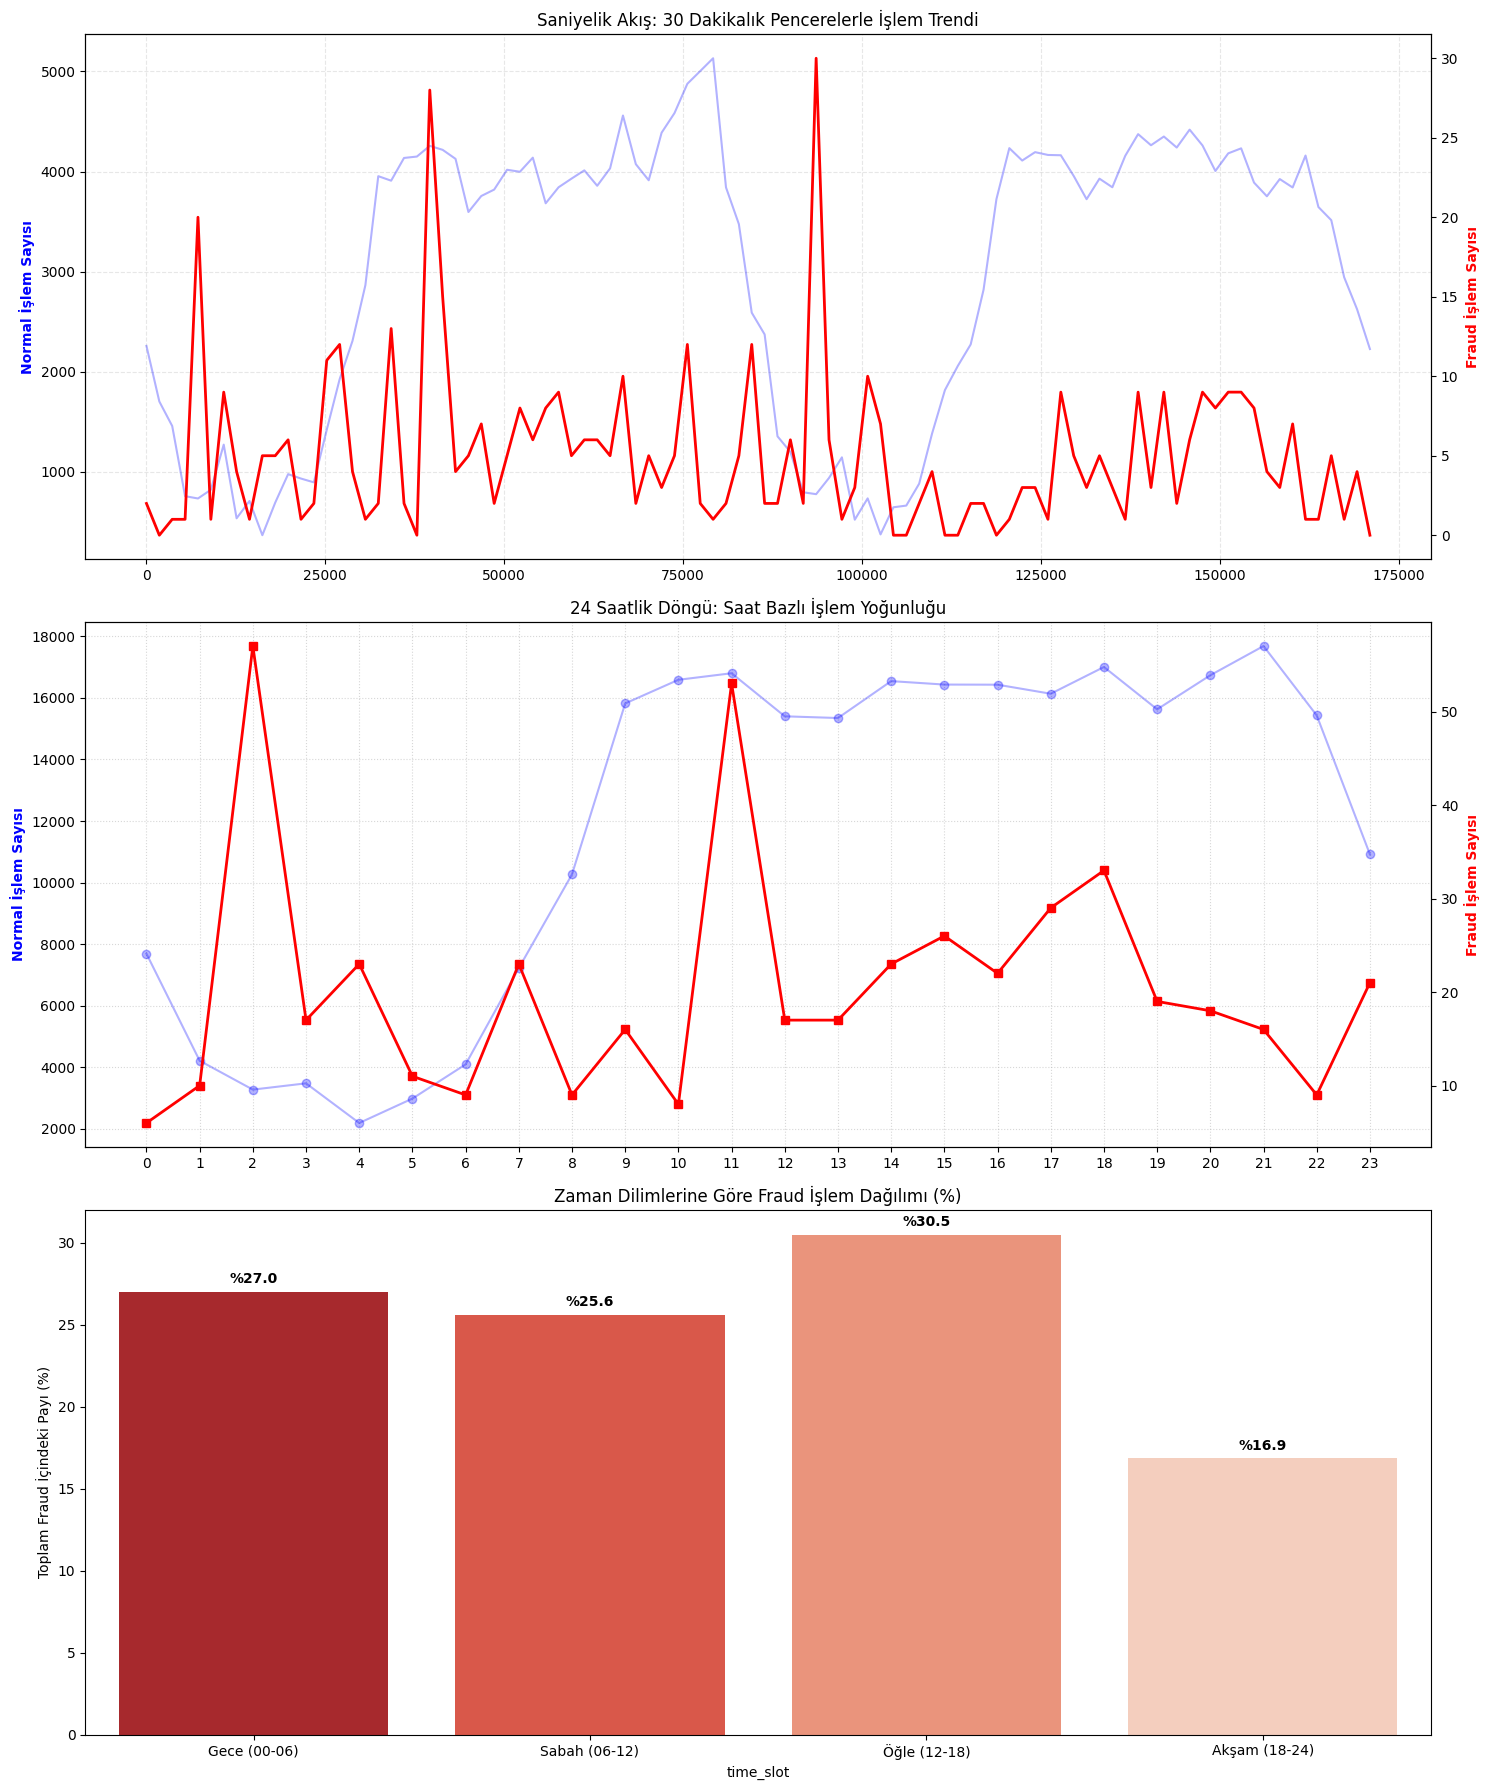

In [10]:
temp_df = df.copy()

window_size = 1800 
temp_df['time_bin'] = (temp_df['Time'] // window_size) * window_size
timeline = temp_df.groupby(['time_bin', 'Class']).size().unstack(fill_value=0).reset_index()

temp_df['hour'] = (temp_df['Time'] // 3600) % 24
hourly_trend = temp_df.groupby(['hour', 'Class']).size().unstack(fill_value=0).reset_index()

bins = [0, 6, 12, 18, 24]
labels = ['Gece (00-06)', 'Sabah (06-12)', 'Öğle (12-18)', 'Akşam (18-24)']
temp_df['time_slot'] = pd.cut(temp_df['hour'], bins=bins, labels=labels, include_lowest=True)
fraud_by_slot = temp_df[temp_df['Class'] == 1]['time_slot'].value_counts(normalize=True).sort_index() * 100

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 18))

ax1.plot(timeline['time_bin'], timeline[0], color='blue', alpha=0.3, label='Normal')
ax1.set_ylabel('Normal İşlem Sayısı', color='blue', fontweight='bold')
ax1_twin = ax1.twinx()
ax1_twin.plot(timeline['time_bin'], timeline[1], color='red', linewidth=2, label='Fraud')
ax1_twin.set_ylabel('Fraud İşlem Sayısı', color='red', fontweight='bold')
ax1.set_title('Saniyelik Akış: 30 Dakikalık Pencerelerle İşlem Trendi')
ax1.grid(True, linestyle='--', alpha=0.3)

ax2.plot(hourly_trend['hour'], hourly_trend[0], color='blue', marker='o', alpha=0.3, label='Normal')
ax2.set_ylabel('Normal İşlem Sayısı', color='blue', fontweight='bold')
ax2.set_xticks(range(0, 24))
ax2_twin = ax2.twinx()
ax2_twin.plot(hourly_trend['hour'], hourly_trend[1], color='red', marker='s', linewidth=2, label='Fraud')
ax2_twin.set_ylabel('Fraud İşlem Sayısı', color='red', fontweight='bold')
ax2.set_title('24 Saatlik Döngü: Saat Bazlı İşlem Yoğunluğu')
ax2.grid(True, linestyle=':', alpha=0.5)

sns.barplot(x=fraud_by_slot.index, y=fraud_by_slot.values, palette="Reds_r", ax=ax3, hue=fraud_by_slot.index, legend=False)
ax3.set_title('Zaman Dilimlerine Göre Fraud İşlem Dağılımı (%)')
ax3.set_ylabel('Toplam Fraud İçindeki Payı (%)')

for p in ax3.patches:
    ax3.annotate(f'%{p.get_height():.1f}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', xytext=(0, 9), 
                 textcoords='offset points', fontweight='bold')

plt.tight_layout()
plt.show()

del temp_df

Saniye ve saat bazlı grafiklerde, önemin daha iyi anlaşılabilmesi için, sınıflar kendi arasında ölçeklenmiştir.
Fraud işlemlerin en yoğun olarak yapıldığı saat, gece 02.00'dır.
İkinci en yüksek olduğu saat da gündüz 11.00'dır ve her iki sınıf için de, gün içi saatleri olduğu için işlem yoğunluğu yüksektir.
Akşam saatlerinde daha az yoğunlukta fraud işlem yapılsa da, genel olarak dörtlü zaman dilimlerinde yüksek bir dark yoktur ddenebilir.

c:\Users\furka\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
c:\Users\furka\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
c:\Users\furka\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
c:\Users\furka\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Doğrulama: 100$ değeri, ölçeklendirilmiş eksende tam olarak 0.5785 noktasına denk gelmeli.


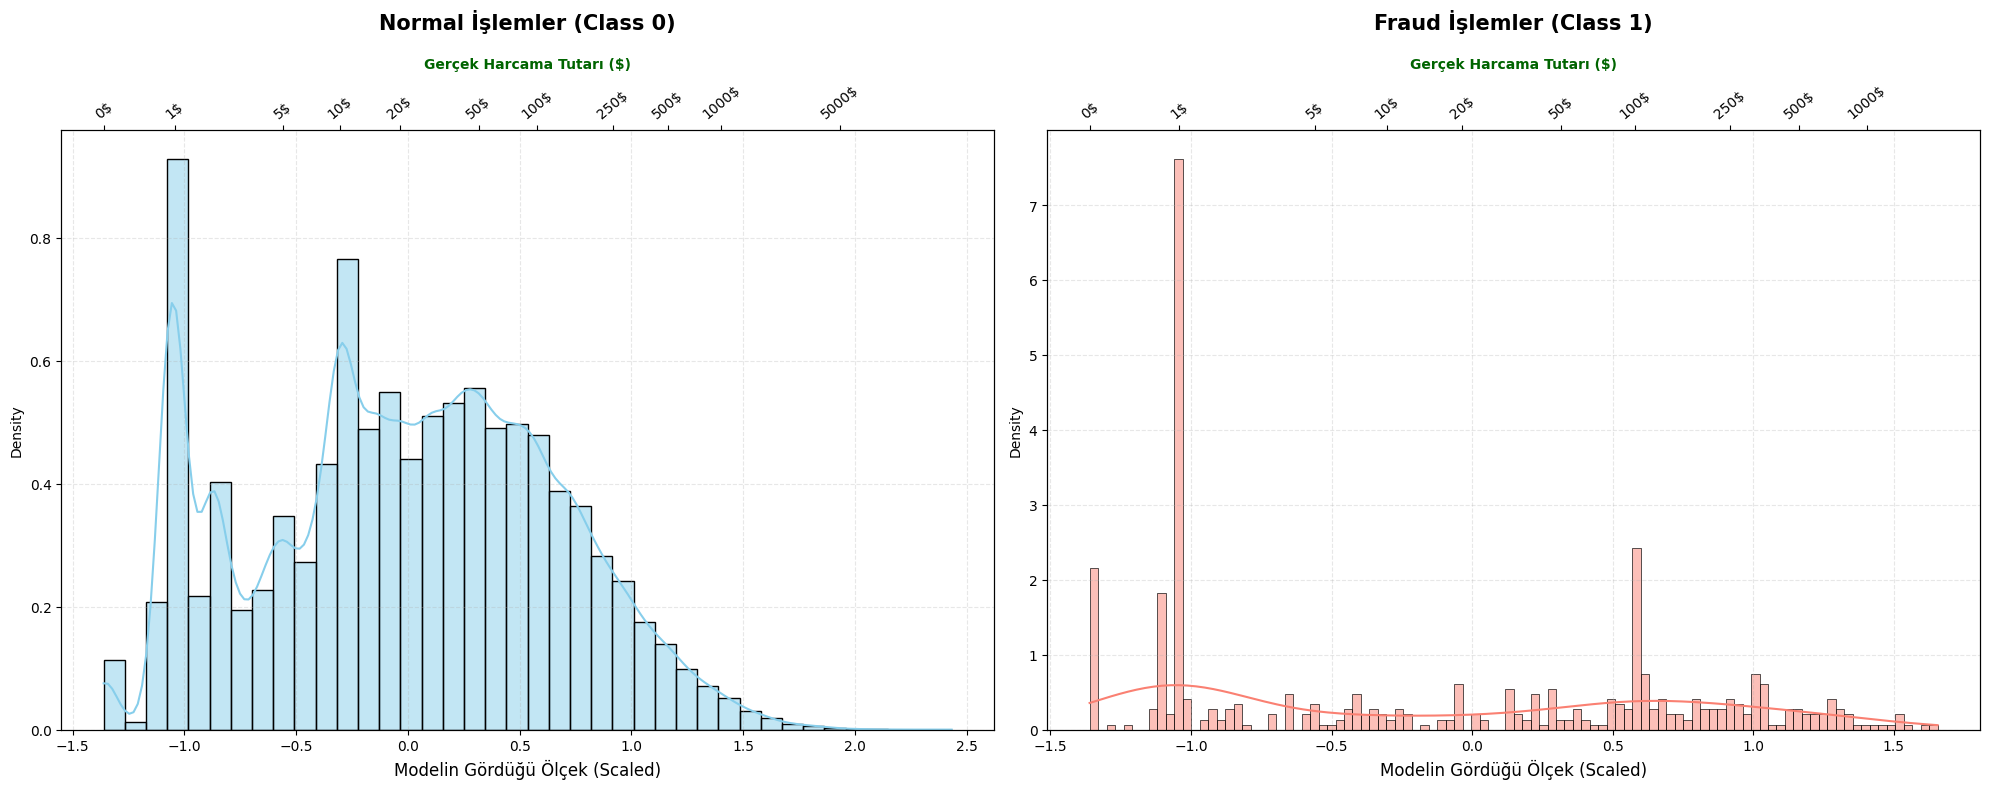

In [ ]:
temp_df = df.copy()

pt = PowerTransformer(method='yeo-johnson')
rs = RobustScaler()

temp_df['Amount_scaled'] = pt.fit_transform(temp_df[['Amount']])
temp_df['Amount_scaled'] = rs.fit_transform(temp_df[['Amount_scaled']])

sample_val = np.array([[100.0]])
expected_scaled = rs.transform(pt.transform(sample_val))[0][0]
print(f"Doğrulama: 100$ değeri, ölçeklendirilmiş eksende tam olarak {expected_scaled:.4f} noktasına denk gelmeli.")

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

original_values = [0, 1, 5, 10, 20, 50, 100, 250, 500, 1000, 5000]
tick_locations = rs.transform(pt.transform(np.array(original_values).reshape(-1, 1))).flatten()
tick_labels = [f"{v}$" for v in original_values]

colors = ['skyblue', 'salmon']
titles = ['Normal İşlemler (Class 0)', 'Fraud İşlemler (Class 1)']

for i, cls in enumerate([0, 1]):
    ax = axes[i]
    data_subset = temp_df[temp_df['Class'] == cls]['Amount_scaled']
    
    current_bins = 100 if cls == 1 else 40
    
    sns.histplot(data_subset, ax=ax, color=colors[i], kde=True, stat="density", alpha=0.5, bins=current_bins)
    
    ax.set_title(titles[i], fontsize=15, fontweight='bold', pad=20)
    ax.set_xlabel('Modelin Gördüğü Ölçek (Scaled)', fontsize=12)
    
    xmin, xmax = ax.get_xlim()
    
    ax_twin = ax.twiny()
    ax_twin.set_xlim(xmin, xmax)
    
    valid_indices = [j for j, loc in enumerate(tick_locations) if xmin <= loc <= xmax]
    ax_twin.set_xticks([tick_locations[j] for j in valid_indices])
    ax_twin.set_xticklabels([tick_labels[j] for j in valid_indices], rotation=40, fontsize=10)
    
    ax_twin.set_xlabel('Gerçek Harcama Tutarı ($)', color='darkgreen', fontweight='bold', labelpad=10)
    ax.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

del temp_df

Fraud sınıfı grafiğinde 2 adet tepe vardır, 0-1 dolar bandı ve 50-250 dolar bandı. 0-1 bandının çok daha baskın olduğunu görüyoruz, bu da kartların denenmesi için yapılmış işlemler olabilir.

In [13]:
X = df.drop("Class", axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=42, 
                                                    stratify=y)

In [14]:
def apply_cyclic_time(df):
    df = df.copy()
    df['hour'] = (df['Time'] / 3600) % 24
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    return df.drop(['Time', 'hour'], axis=1)

X_train = apply_cyclic_time(X_train)
X_test = apply_cyclic_time(X_test)

In [ ]:
pt = PowerTransformer(method='yeo-johnson')
rs = RobustScaler()

X_train_scaled = rs.fit_transform(pt.fit_transform(X_train))
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)


smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled_df, y_train)

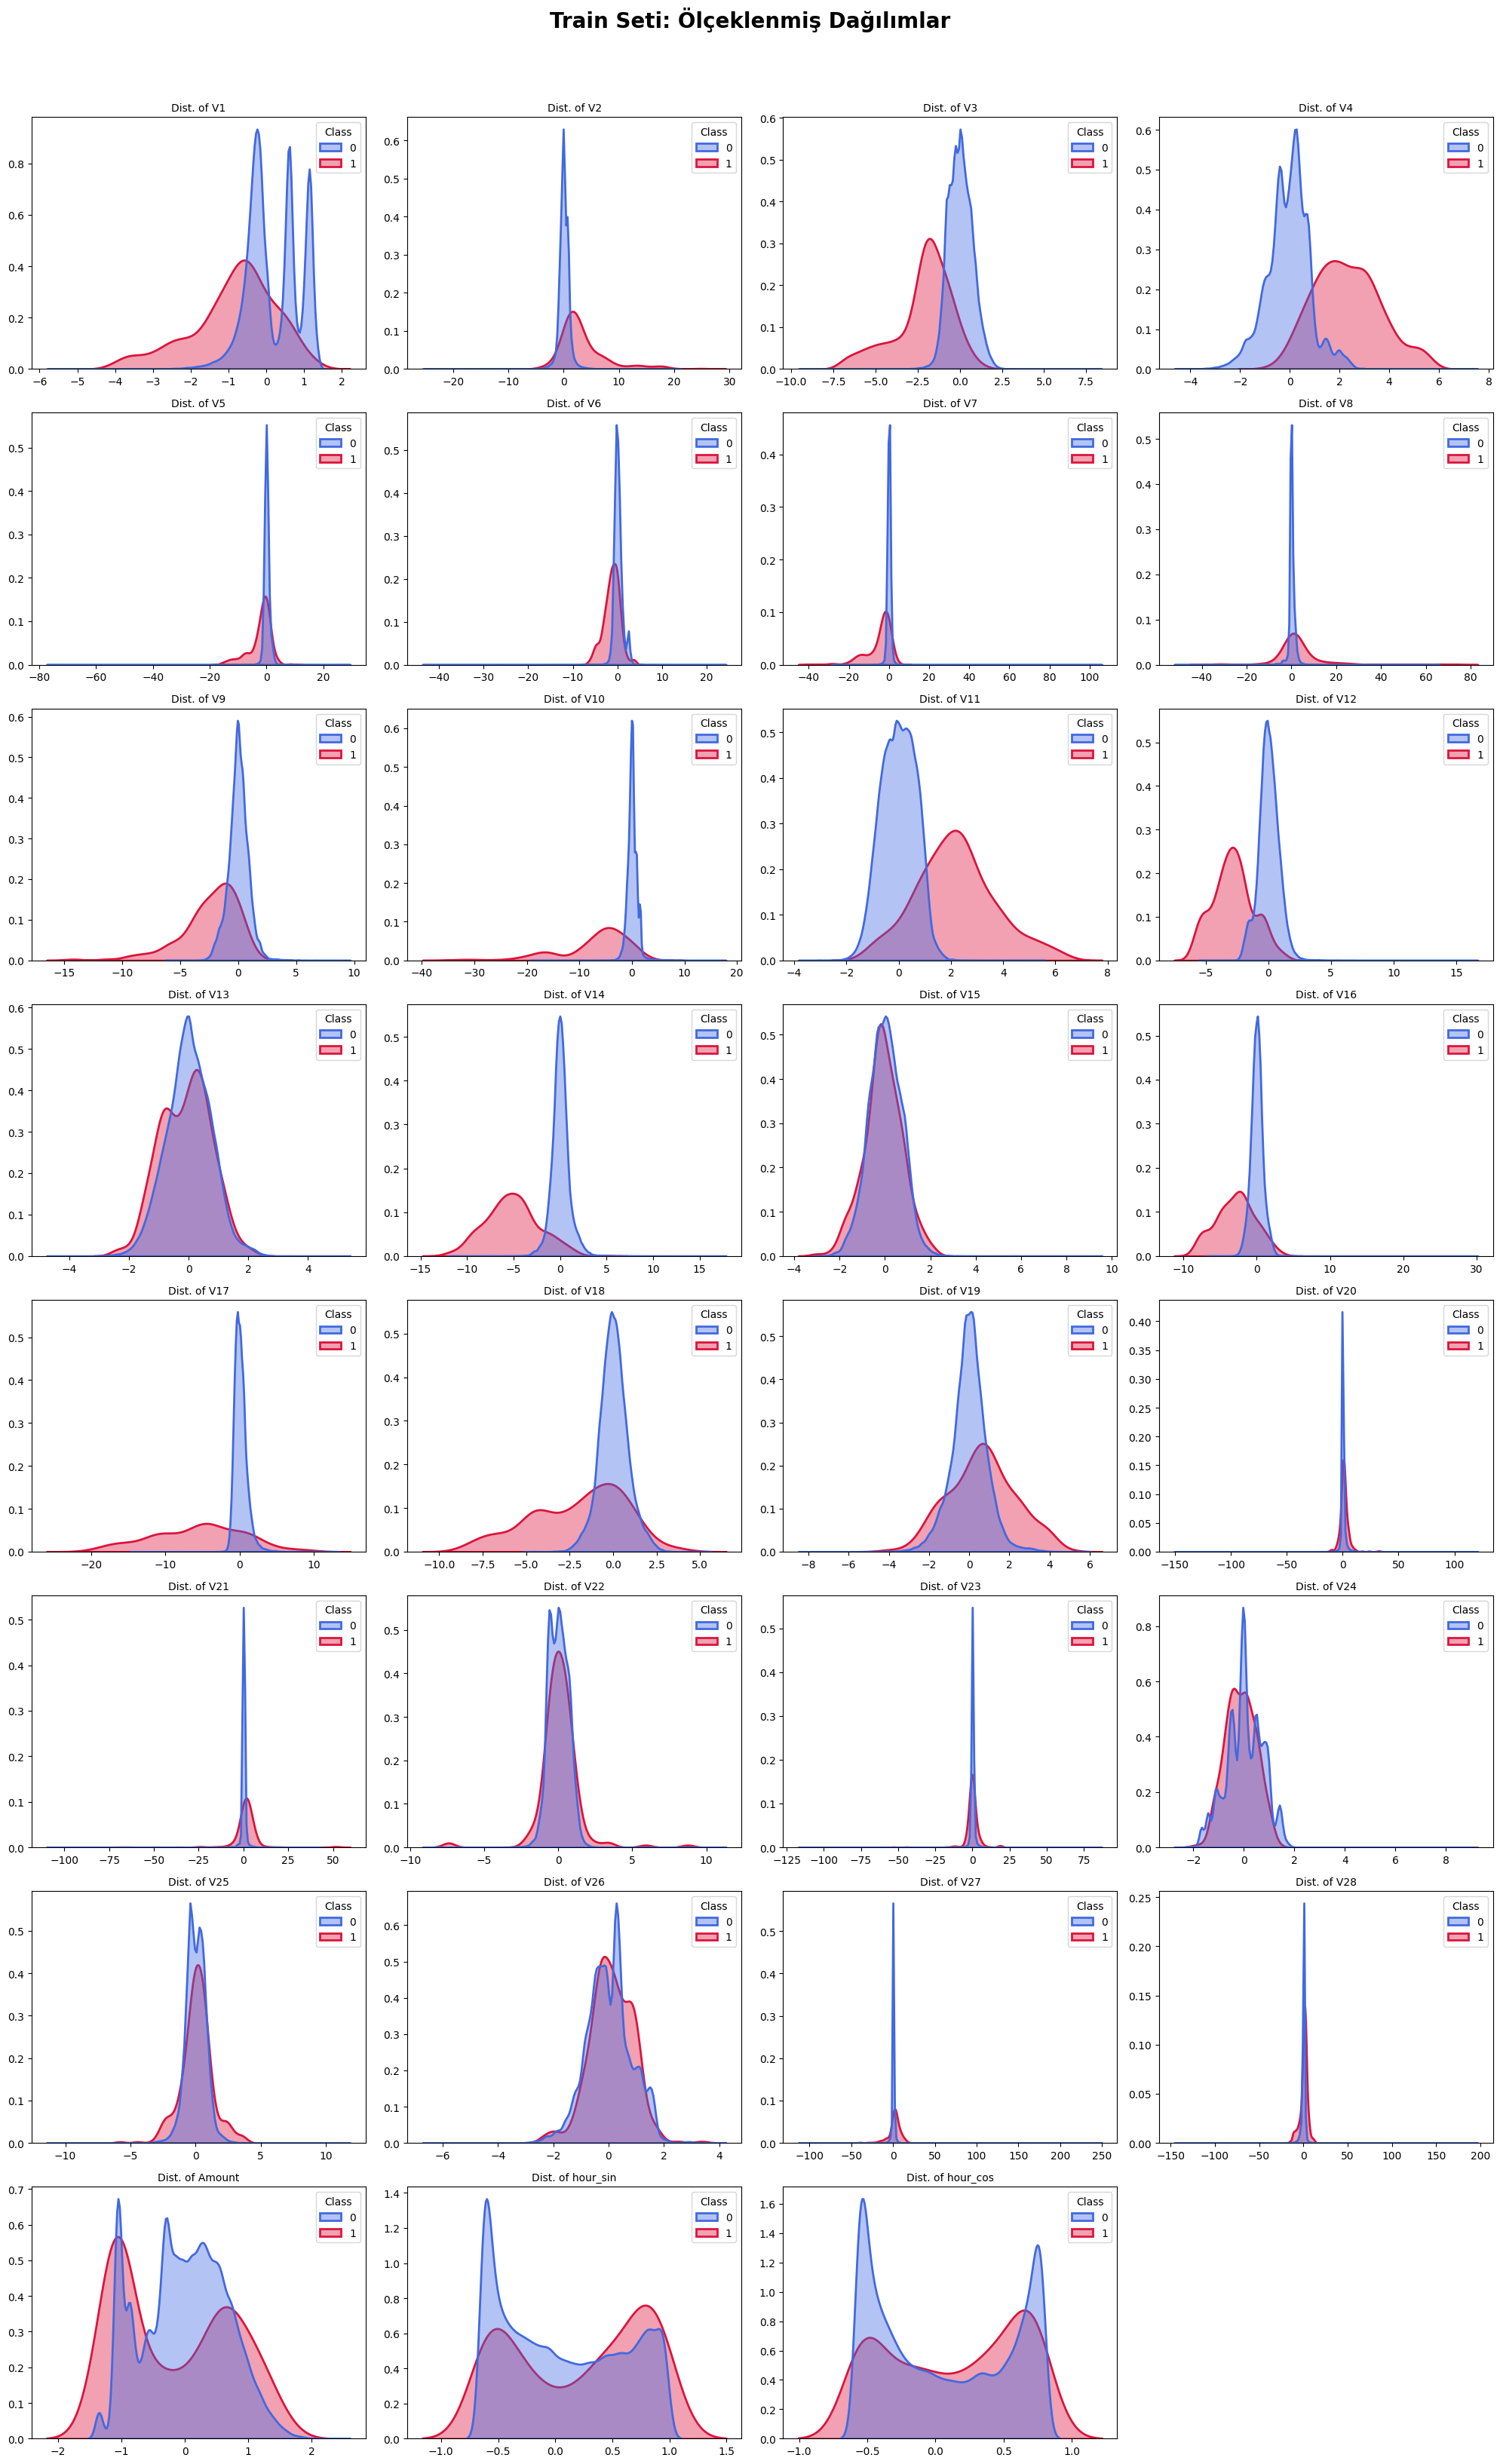

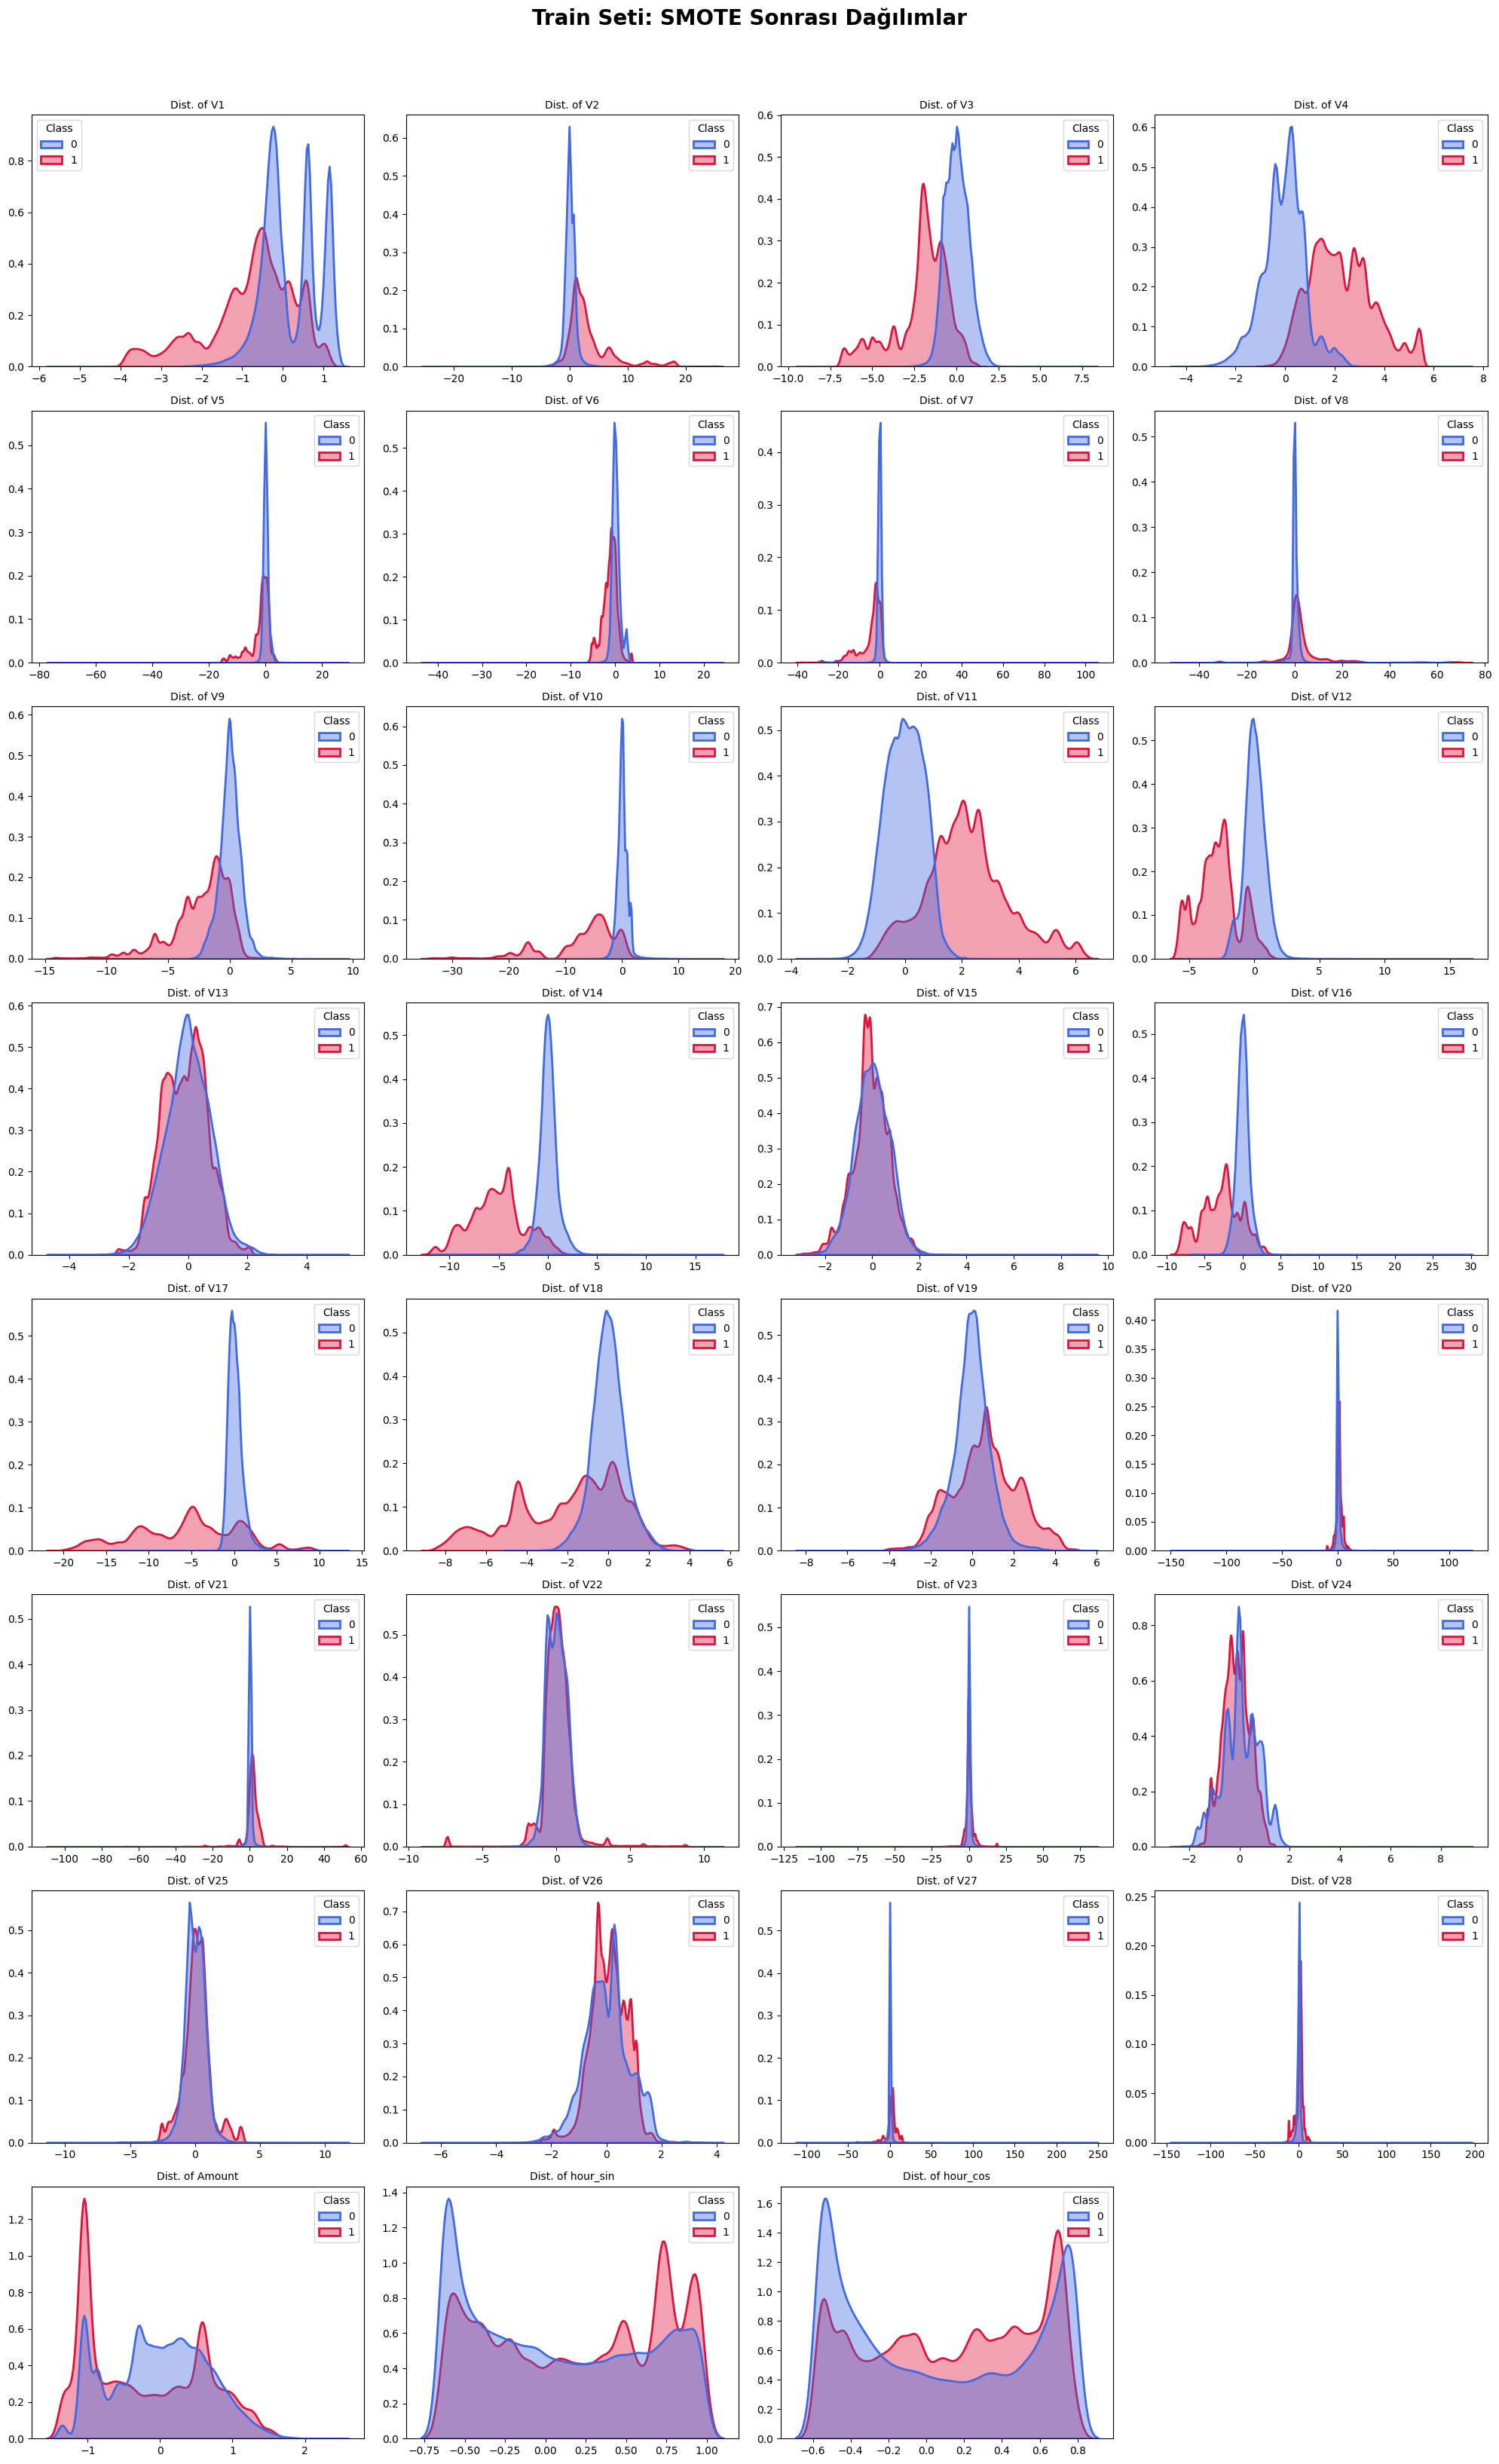

In [ ]:
def plot_kde_distributions(X, y, title):
    
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X, columns=X_train.columns)
    
    y_vals = y.values if hasattr(y, 'values') else y
    
    temp_df = X.copy()
    temp_df['Class'] = y_vals
    
    cols = X.columns
    n_cols = 4
    n_rows = math.ceil(len(cols) / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
    fig.suptitle(title, fontsize=20, fontweight='bold', y=1.02)
    axes = axes.flatten()

    for i, col in enumerate(cols):
        sns.kdeplot(
            data=temp_df, x=col, hue="Class", 
            fill=True, common_norm=False,
            palette={0: "royalblue", 1: "crimson"},
            alpha=0.4, linewidth=2, ax=axes[i]
        )
        axes[i].set_title(f'Dist. of {col}', fontsize=10)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


plot_kde_distributions(X_train_scaled_df, y_train, "Train Seti: Ölçeklenmiş Dağılımlar")

)
plot_kde_distributions(X_train_resampled, y_train_resampled, "Train Seti: SMOTE Sonrası Dağılımlar")

Bazı değişkenlerde Normal ve Fraud sınıflarının dağılımları direkt uyuşuyor, bazılarında ise bariz belirgin dağılım farkları var.
Dağılımların çok sivri gözükmesinin sebebi ölçekler ve veri sayısının fazla olması ve birbirine yakın değerlere sahip olmalarıdır.
common_norm = False seçtiğimiz için, olasılık dağılımlarında grafiğin iç kısım alanının 1'e eşit olması he sınıfın dağılımını kendine göre ayrı ayrı görebilmemizi sağlıyor.
SMOTE uygulanmış ve uygulanmamış değişken grafiklerinde, değişkenlerin dağılımında tepelerin sivrileşmesi, SMOTE algoritmasının değişkenlerin yoğun olduğu yerlerde daha çok sentetik veri üretildiğini gösteriyor.

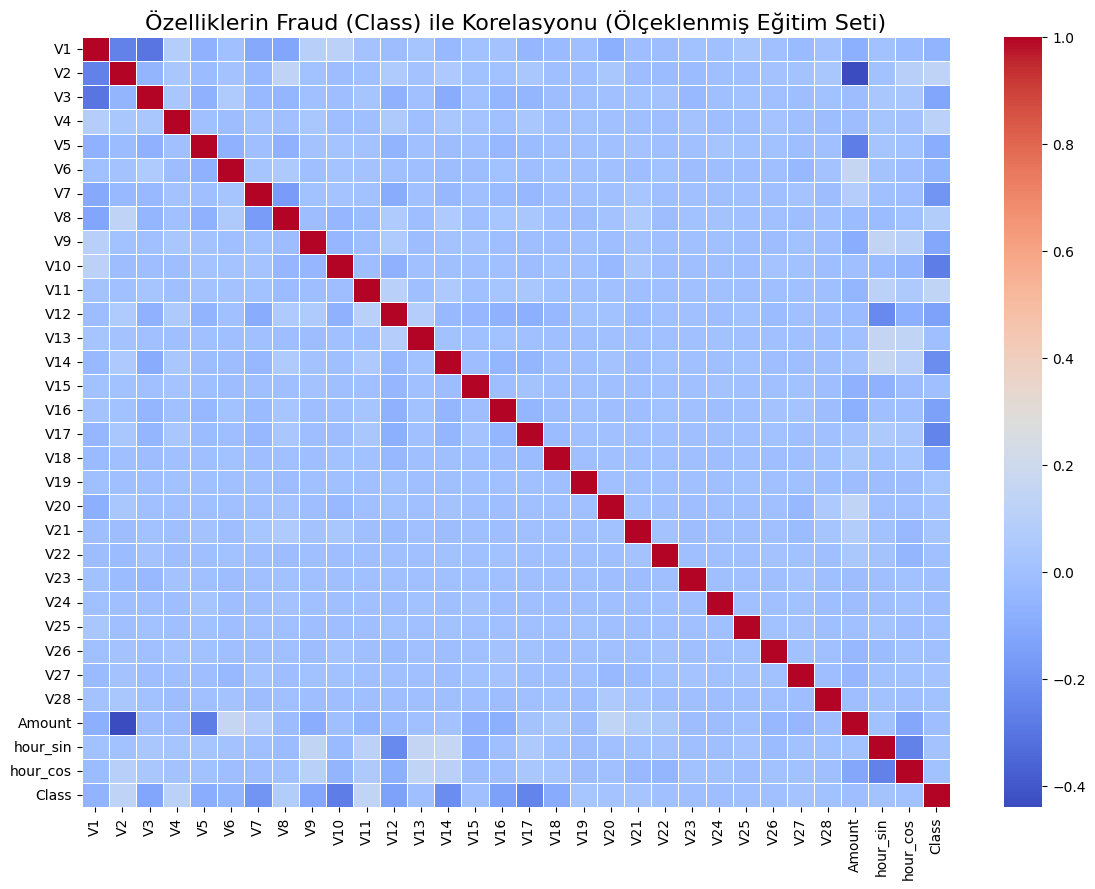

--- Fraud (Class) ile En Yüksek Pozitif Korelasyonlar ---
Class    1.000000
V11      0.134677
V2       0.131021
V4       0.113238
Name: Class, dtype: float64

--- Fraud (Class) ile En Yüksek Negatif Korelasyonlar ---
V18   -0.100332
V9    -0.114682
V3    -0.124056
V12   -0.140693
V16   -0.142087
V7    -0.187315
V14   -0.215930
V17   -0.252962
V10   -0.271444
Name: Class, dtype: float64


In [ ]:
corr_data = X_train_scaled_df.copy()
corr_data['Class'] = y_train.values

corr_matrix = corr_data.corr()


plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title("Özelliklerin Fraud (Class) ile Korelasyonu (Ölçeklenmiş Eğitim Seti)", fontsize=16)
plt.show()

fraud_correlations = corr_matrix['Class'].sort_values(ascending=False)

print("--- Fraud (Class) ile En Yüksek Pozitif Korelasyonlar ---")
print(fraud_correlations[fraud_correlations > 0.1])

print("\n--- Fraud (Class) ile En Yüksek Negatif Korelasyonlar ---")
print(fraud_correlations[fraud_correlations < -0.1])

Class'a göre korelasyona bakacak olursak, pozitif- negatif farketmeksizin çok yüksek korelasyonlar olmadığı için, değişkenler birbirlerine yakın oranda bilgi taşıma kapasitesine sahiptir.

In [16]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.05, random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=100, random_state=42, verbose=-1),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(iterations=100, verbose=0, random_state=42)
}

In [21]:
final_results = []

for name, model in models.items():
    pipe = Pipeline([
        ('yeo_johnson', PowerTransformer(method='yeo-johnson')),
        ('robust_scaler', RobustScaler()),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    
    cv_results = cross_validate(pipe, X_train, y_train, 
                                cv=5, 
                                scoring=['average_precision', 'recall'],
                                n_jobs=-1)
    
    final_results.append({
        "Model": name,
        "AUPRC (Ortalama)": cv_results['test_average_precision'].mean(),
        "Recall (Ortalama)": cv_results['test_recall'].mean()
    })

results_df = pd.DataFrame(final_results).sort_values(by="AUPRC (Ortalama)", ascending=False)
print(results_df)

                 Model  AUPRC (Ortalama)  Recall (Ortalama)
5             CatBoost          0.810922           0.812074
3        Random Forest          0.792596           0.839955
2             LightGBM          0.785184           0.817235
4             AdaBoost          0.762679           0.888186
1              XGBoost          0.762229           0.885622
0  Logistic Regression          0.760626           0.913599


In [ ]:
scale_weight = (y_train == 0).sum() / (y_train == 1).sum()


models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=4, scale_pos_weight=scale_weight, random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=100, scale_pos_weight=scale_weight, random_state=42, verbose=-1),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42), 
    "CatBoost": CatBoostClassifier(iterations=100, auto_class_weights='Balanced', verbose=0, random_state=42)
}

final_results = []

print("--- Modeller Class Weight ile (SMOTE'suz) Eğitiliyor ---")

for name, model in models.items():
   
    pipe = Pipeline([
        ('yeo_johnson', PowerTransformer(method='yeo-johnson')),
        ('robust_scaler', RobustScaler()),
        ('classifier', model)
    ])
    
  
    cv_results = cross_validate(pipe, X_train, y_train, 
                                cv=5, 
                                scoring=['average_precision', 'recall'],
                                n_jobs=-1)
    
    final_results.append({
        "Model": name,
        "AUPRC (Ortalama)": cv_results['test_average_precision'].mean(),
        "Recall (Ortalama)": cv_results['test_recall'].mean()
    })

results_df = pd.DataFrame(final_results).sort_values(by="AUPRC (Ortalama)", ascending=False)
print(results_df)

--- Modeller Class Weight ile (SMOTE'suz) Eğitiliyor ---


c:\Users\furka\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


                 Model  AUPRC (Ortalama)  Recall (Ortalama)
1              XGBoost          0.841177           0.814638
5             CatBoost          0.813906           0.812074
3        Random Forest          0.812890           0.786693
0  Logistic Regression          0.763133           0.911068
4             AdaBoost          0.712183           0.669653
2             LightGBM          0.020456           0.875495


Veri setindeki aşırı dengesizlik nedeniyle accuracy gibi metrikler yanıltıcı sonuçlar verdiğinden, sadece dolandırıcılık vakalarına odaklanan AUPRC tercih edilmiştir. Bu metrik, hırsızları yakalama başarısı ile yanlış alarm verme oranı arasındaki dengeyi yakalamada ROC-AUC'dan çok daha başarılıdır.

Lojistik Regresyon ve Bagging-Boosting algoritmaları SMOTE yöntemi kullanılarak ve verinin kendi içindeki doğal ağırlığı kullanılarak iki kez ayrı ayrı eğitilmiştir.

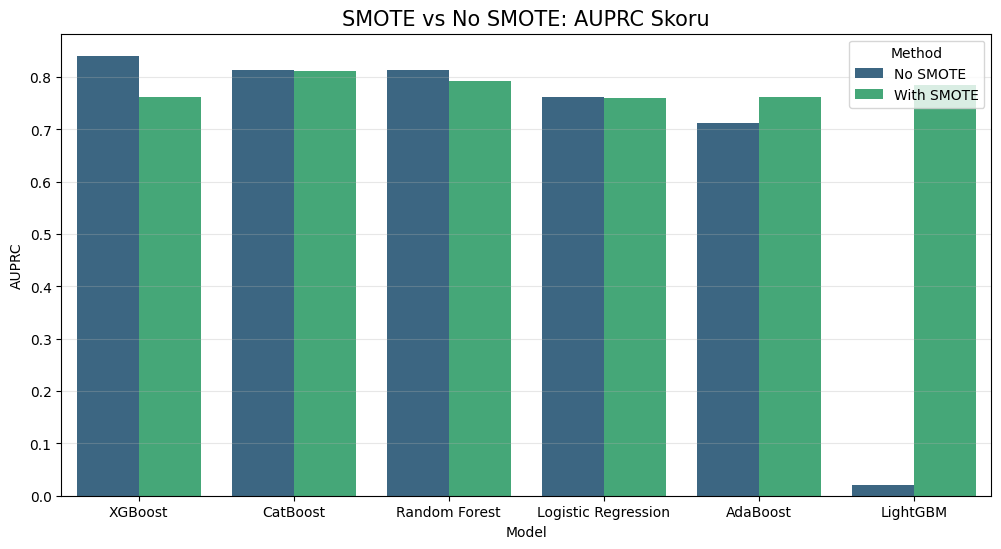

In [ ]:
data = {
    'Model': ['XGBoost', 'CatBoost', 'Random Forest', 'Logistic Regression', 'AdaBoost', 'LightGBM'] * 2,
    'AUPRC': [0.841, 0.814, 0.813, 0.763, 0.712, 0.020,  
              0.762, 0.811, 0.793, 0.761, 0.763, 0.785], 
    'Recall': [0.815, 0.812, 0.787, 0.911, 0.670, 0.875, 
               0.886, 0.812, 0.840, 0.914, 0.888, 0.817], 
    'Method': ['No SMOTE']*6 + ['With SMOTE']*6
}
df_comp = pd.DataFrame(data)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_comp, x='Model', y='AUPRC', hue='Method', palette='viridis')
plt.title('SMOTE vs No SMOTE: AUPRC Skoru', fontsize=15)
plt.grid(axis='y', alpha=0.3)
plt.show()

Aynı modellerin SMOTE ve ağırlıkla eğitilmiş hallerine baktığımız zaman, ağırlıkla eğitilmiş olan modellerin AUPRC ve Recall skorlarının daha yüksek çıkması sentetik verilere ihtiyaç olmadığını gösteriyor. Çoğunlukla olduğu gibi, yine boosting modelleri daha iyi performans gösterdiği için üst sıralarda.


 MODEL: XGBoost (Weighted)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.81      0.84      0.82        98

    accuracy                           1.00     56962
   macro avg       0.91      0.92      0.91     56962
weighted avg       1.00      1.00      1.00     56962


 MODEL: CatBoost (Weighted)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.67      0.85      0.75        98

    accuracy                           1.00     56962
   macro avg       0.83      0.92      0.87     56962
weighted avg       1.00      1.00      1.00     56962



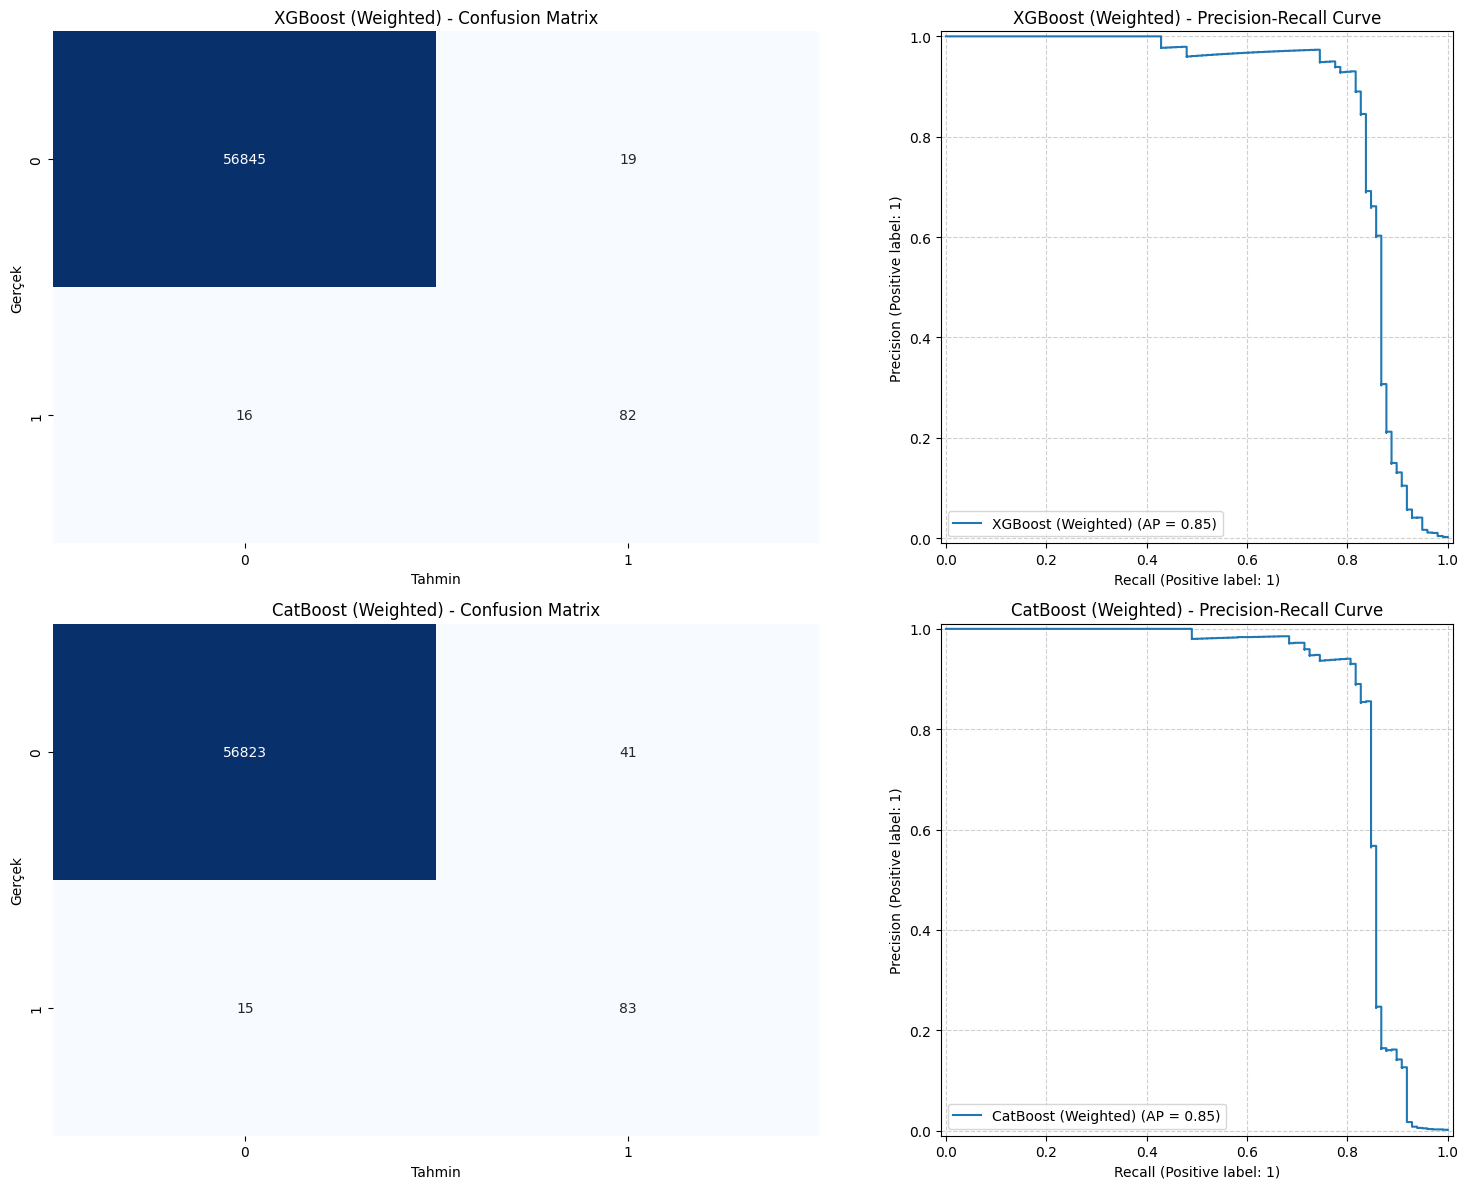

In [ ]:
scale_weight = (y_train == 0).sum() / (y_train == 1).sum()

top_models = {
    "XGBoost (Weighted)": XGBClassifier(scale_pos_weight=scale_weight, n_estimators=100, max_depth=4, random_state=42),
    "CatBoost (Weighted)": CatBoostClassifier(auto_class_weights='Balanced', iterations=100, verbose=0, random_state=42)
}

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for i, (name, model) in enumerate(top_models.items()):
    
    pipe = Pipeline([
        ('yeo_johnson', PowerTransformer(method='yeo-johnson')),
        ('robust_scaler', RobustScaler()),
        ('classifier', model)
    ])
    
    
    pipe.fit(X_train, y_train)
    
    
    y_pred = pipe.predict(X_test)
    y_probs = pipe.predict_proba(X_test)[:, 1]
    
    
    print(f"\n" + "="*40)
    print(f" MODEL: {name}")
    print("="*40)
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i, 0], cbar=False)
    axes[i, 0].set_title(f"{name} - Confusion Matrix")
    axes[i, 0].set_xlabel('Tahmin')
    axes[i, 0].set_ylabel('Gerçek')
    
    
    display = PrecisionRecallDisplay.from_predictions(y_test, y_probs, ax=axes[i, 1], name=name)
    axes[i, 1].set_title(f"{name} - Precision-Recall Curve")
    axes[i, 1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

XGBoost ve Catboost modellerinin confusion matrixlerini kıyasladığımızda, Catboostun +1 daha fazla fraud yakalayıp +22 fraud olmayan müşteriyi rahatsız etmesi, model seçimini müşteri memnuniyetine göre bankanın kararına bırakır. Genel başarılarda bu iki model en yüksek çıktığı için, Hiperparametre optimizasyonu ile daha iyi sonuçlar alınmaya çalışılabilir.

In [33]:
def objective(trial):
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'scale_pos_weight': scale_weight, 
        'random_state': 42,
        'verbosity': 0
    }

    
    pipe = Pipeline([
        ('yeo', PowerTransformer(method='yeo-johnson')),
        ('scaler', RobustScaler()),
        ('classifier', XGBClassifier(**params))
    ])

    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='average_precision', n_jobs=-1)

    return score.mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30) 

print(f"En İyi AUPRC Skoru: {study.best_value:.4f}")
print(f"En İyi Parametreler: {study.best_params}")

[I 2026-01-28 15:07:54,747] A new study created in memory with name: no-name-57c1ceac-e475-4d1a-9654-1d3fbdafac02
[I 2026-01-28 15:08:31,780] Trial 0 finished with value: 0.83998285083646 and parameters: {'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.18443019532526592, 'subsample': 0.8118053217186182, 'colsample_bytree': 0.8462718413934663, 'min_child_weight': 16}. Best is trial 0 with value: 0.83998285083646.
[I 2026-01-28 15:09:11,007] Trial 1 finished with value: 0.854114062676864 and parameters: {'n_estimators': 900, 'max_depth': 6, 'learning_rate': 0.050027836735222424, 'subsample': 0.8961779747189235, 'colsample_bytree': 0.9343832076488651, 'min_child_weight': 6}. Best is trial 1 with value: 0.854114062676864.
[I 2026-01-28 15:09:38,918] Trial 2 finished with value: 0.8431083251149658 and parameters: {'n_estimators': 600, 'max_depth': 6, 'learning_rate': 0.1866663281448602, 'subsample': 0.9768188819327265, 'colsample_bytree': 0.9559701167534983, 'min_child_weight': 7}

En İyi AUPRC Skoru: 0.8541
En İyi Parametreler: {'n_estimators': 900, 'max_depth': 6, 'learning_rate': 0.050027836735222424, 'subsample': 0.8961779747189235, 'colsample_bytree': 0.9343832076488651, 'min_child_weight': 6}


In [ ]:
best_xgb_pipe = Pipeline([
    ('yeo', PowerTransformer(method='yeo-johnson')),
    ('scaler', RobustScaler()),
    ('classifier', XGBClassifier(**study.best_params, scale_pos_weight=scale_weight))
])

best_xgb_pipe.fit(X_train, y_train)

y_probs = best_xgb_pipe.predict_proba(X_test)[:, 1]
print(f"Final Optimized AUPRC: {average_precision_score(y_test, y_probs):.4f}")

Final Optimized AUPRC: 0.8821


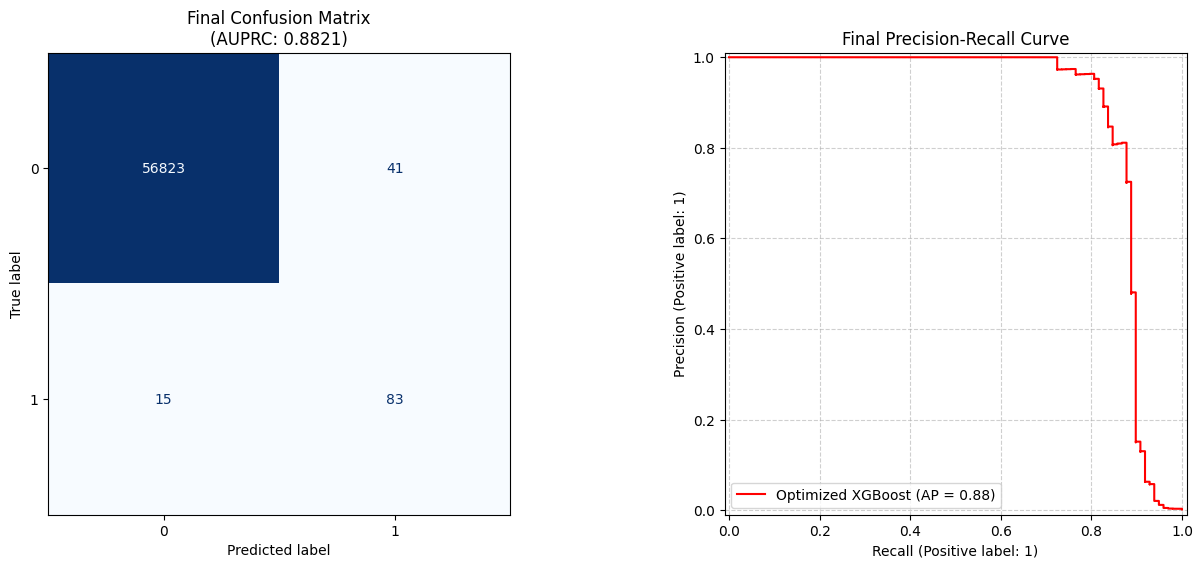

In [35]:
final_auprc = average_precision_score(y_test, y_probs)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax[0], cmap='Blues', colorbar=False)
ax[0].set_title(f"Final Confusion Matrix\n(AUPRC: {final_auprc:.4f})")

PrecisionRecallDisplay.from_predictions(y_test, y_probs, ax=ax[1], name="Optimized XGBoost", color="red")
ax[1].set_title("Final Precision-Recall Curve")
ax[1].grid(True, linestyle='--', alpha=0.6)

Hiperparametre optimizasyonu çıktısından aldığımız en iyi parametrelerle 0.8821 gibi çok iyi bir sonuç elde ettik fakat confusion matriximiz optimize edilmemiş Catboost ile aynı çıktı. F1-Skoru ve Recall duyarlı iki ayrı şekilde, sınıflandırırken en iyi eşik değerinin seçildiği iki ayrı confusion matrix yapacağız.

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# 2. F1-Score'u her eşik için hesapla (F1 = 2 * (P*R) / (P+R))
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"En İyi F1-Score'u Veren Eşik: {best_threshold:.4f}")

# 3. Yeni eşiğe göre tahmin yap (0.5 yerine best_threshold kullan)
y_pred_tuned = (y_probs >= best_threshold).astype(int)

# 4. Yeni Confusion Matrix
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_tuned))

En İyi F1-Score'u Veren Eşik: 0.9619
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.82      0.88        98

    accuracy                           1.00     56962
   macro avg       0.98      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962



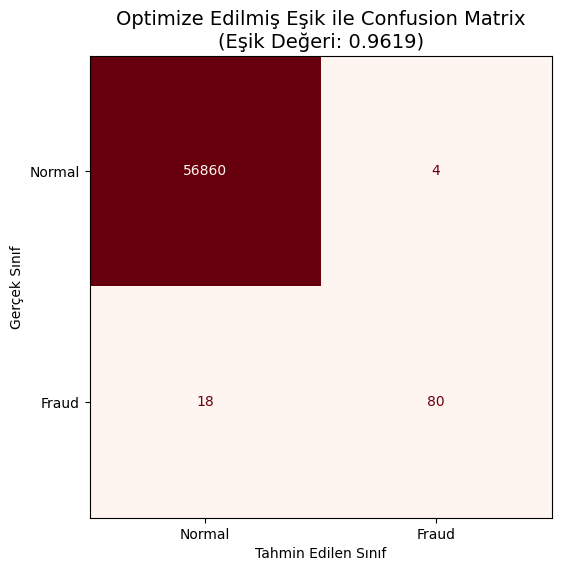

--- Yeni Eşik Özeti ---
Yakalanan Fraud (TP): 80
Kaçan Fraud (FN): 18
Yanlış Alarm (FP): 4


In [37]:
cm_tuned = confusion_matrix(y_test, y_pred_tuned)

# 2. Görselleştirme
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tuned, display_labels=['Normal', 'Fraud'])

# Fraud işlemlerine odaklandığımız için 'Reds' veya 'YlOrRd' paleti çok yakışır
disp.plot(ax=ax, cmap='Reds', values_format='d', colorbar=False)

plt.title(f"Optimize Edilmiş Eşik ile Confusion Matrix\n(Eşik Değeri: {best_threshold:.4f})", fontsize=14)
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.show()

# Değişimi anlamak için kısa özet
tn, fp, fn, tp = cm_tuned.ravel()
print(f"--- Yeni Eşik Özeti ---")
print(f"Yakalanan Fraud (TP): {tp}")
print(f"Kaçan Fraud (FN): {fn}")
print(f"Yanlış Alarm (FP): {fp}")

F1 skor için eşik değerini en iyi olacak şekilde seçtiğimizde,  yanlış alarmlarımız gözle görülür biçimde düşmüştür fakat 3 fraudun kaçmasına sebep olmuştur.
Recall hedefini 0.90 yaptığımızda gelen en iyi eşik değeriyle gelen confusipn matrix sonucu yalnızca 4 tane fraud kaçırmamızı sağlarken, 499 yanlış alarm ile müşter memnuniyeti açısından çok pahalıya patlamıştır.

In [39]:
def catboost_objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000, step=100),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 0, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'auto_class_weights': 'Balanced',
        'bootstrap_type': 'Bernoulli', # Dengesiz veride iyi sonuç verir
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'verbose': 0,
        'random_state': 42
    }

    pipe = Pipeline([
        ('yeo', PowerTransformer(method='yeo-johnson')),
        ('scaler', RobustScaler()),
        ('classifier', CatBoostClassifier(**params))
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # AUPRC için 'average_precision' kullanmaya devam ediyoruz
    score = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='average_precision', n_jobs=-1)

    return score.mean()

# Çalışmayı başlat
cb_study = optuna.create_study(direction='maximize')
cb_study.optimize(catboost_objective, n_trials=30)

print(f"En İyi CatBoost AUPRC: {cb_study.best_value:.4f}")

[I 2026-01-28 15:35:30,554] A new study created in memory with name: no-name-03b78877-e657-45d0-a73e-66554f807a72
[I 2026-01-28 15:35:53,379] Trial 0 finished with value: 0.7802771633168254 and parameters: {'iterations': 100, 'depth': 7, 'learning_rate': 0.05908698579770067, 'l2_leaf_reg': 5.410299648007114, 'random_strength': 3.4494841697859178, 'border_count': 136, 'subsample': 0.8585251449205038}. Best is trial 0 with value: 0.7802771633168254.
[I 2026-01-28 15:36:46,988] Trial 1 finished with value: 0.713051643604035 and parameters: {'iterations': 600, 'depth': 4, 'learning_rate': 0.019217698540088566, 'l2_leaf_reg': 7.150099148908067, 'random_strength': 7.609615747188137, 'border_count': 173, 'subsample': 0.734768338081749}. Best is trial 0 with value: 0.7802771633168254.
[I 2026-01-28 15:37:06,773] Trial 2 finished with value: 0.7367347375968691 and parameters: {'iterations': 100, 'depth': 6, 'learning_rate': 0.05767300665273134, 'l2_leaf_reg': 6.1551074425045575, 'random_strengt

KeyboardInterrupt: 

In [40]:
try:
    print(f"Şu ana kadarki en iyi skor: {cb_study.best_value:.4f}")
    print(f"En iyi parametreler: {cb_study.best_params}")
except:
    print("Henüz hiçbir deneme tamamlanmamış.")

Şu ana kadarki en iyi skor: 0.8454
En iyi parametreler: {'iterations': 1000, 'depth': 9, 'learning_rate': 0.014154429765714295, 'l2_leaf_reg': 2.212867603141732, 'random_strength': 1.5499106874242026, 'border_count': 121, 'subsample': 0.8980681496009697}


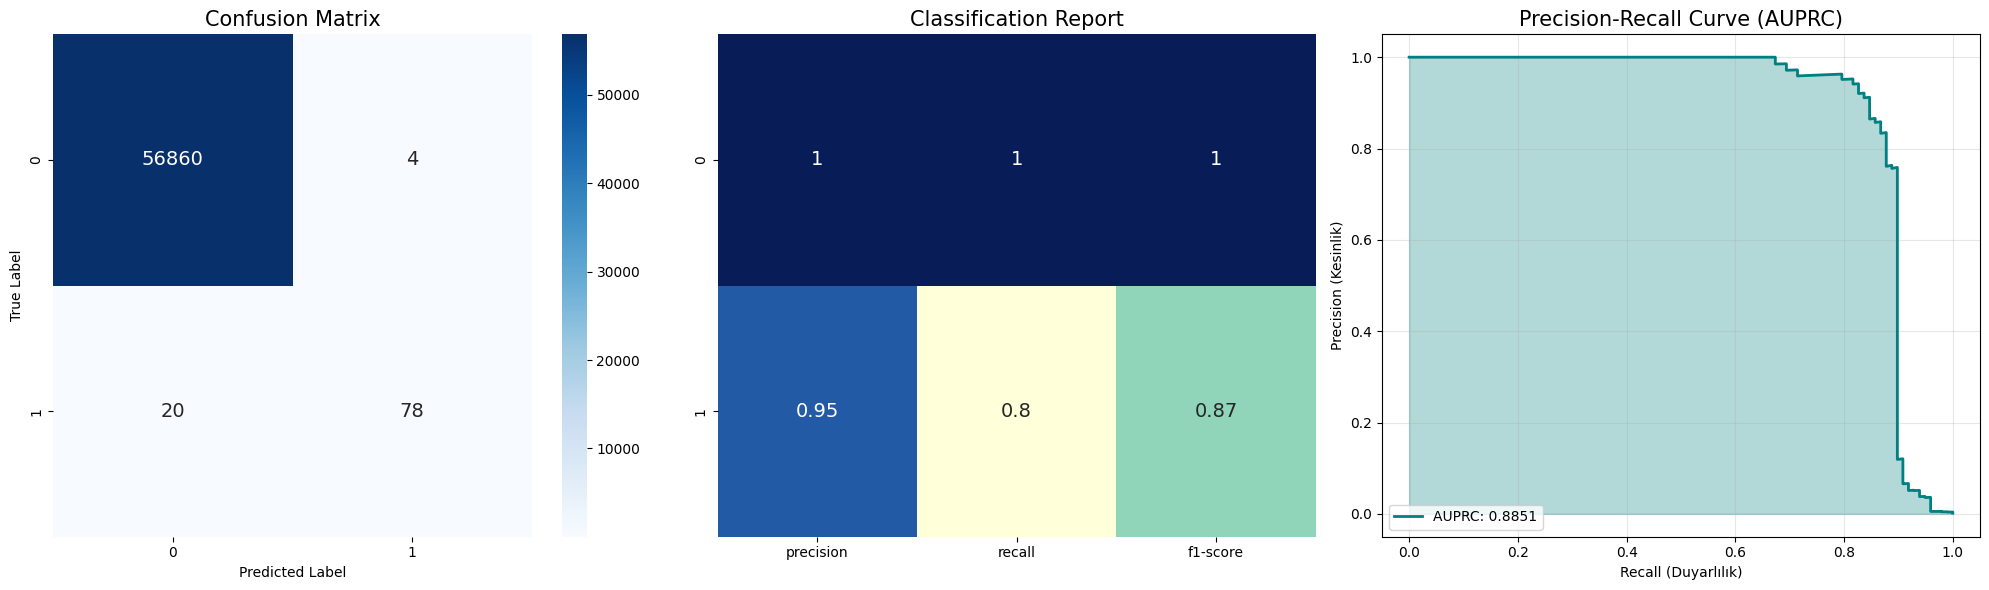

In [44]:
best_params = {
    'iterations': 1000,
    'depth': 9,
    'learning_rate': 0.014154429765714295,
    'l2_leaf_reg': 2.212867603141732,
    'random_strength': 1.5499106874242026,
    'border_count': 121,
    'subsample': 0.8980681496009697,
    'verbose': 0, # Eğitim loglarını gizlemek için
    'random_seed': 42
}

# 2. Modelin Eğitilmesi (X_train ve y_train verilerinizin hazır olduğunu varsayıyoruz)
model = CatBoostClassifier(**best_params)
model.fit(X_train, y_train)

# 3. Tahminlerin Alınması
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:, 1]

# 4. Metriklerin Hazırlanması
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).iloc[:-1, :2].T # Sınıf bazlı rapor
precision, recall, _ = precision_recall_curve(y_test, y_probs)
auprc_score = auc(recall, precision)

# 5. Görselleştirme (Yan Yana 3 Grafik)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Panel 1: Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], annot_kws={"size": 14})
axes[0].set_title('Confusion Matrix', fontsize=15)
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Panel 2: Classification Report Heatmap
sns.heatmap(df_report, annot=True, cmap='YlGnBu', ax=axes[1], cbar=False, annot_kws={"size": 14})
axes[1].set_title('Classification Report', fontsize=15)

# Panel 3: AUPRC Curve
axes[2].plot(recall, precision, color='teal', lw=2, label=f'AUPRC: {auprc_score:.4f}')
axes[2].fill_between(recall, precision, alpha=0.3, color='teal')
axes[2].set_xlabel('Recall (Duyarlılık)')
axes[2].set_ylabel('Precision (Kesinlik)')
axes[2].set_title('Precision-Recall Curve (AUPRC)', fontsize=15)
axes[2].legend(loc="lower left")
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

optimize XGBoost ile kıyaslandığı zaman, AUPRC 0.0030 daha yüksek bir sonuç verse de, confusion matrix kalitesi bakımında n tun edilmiş xgboost çok daha iyi sonuçlar veriyor.

C:\Users\furka\AppData\Local\Temp\ipykernel_15752\2254624139.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_plot, x='AUPRC', y='Model', palette=colors)


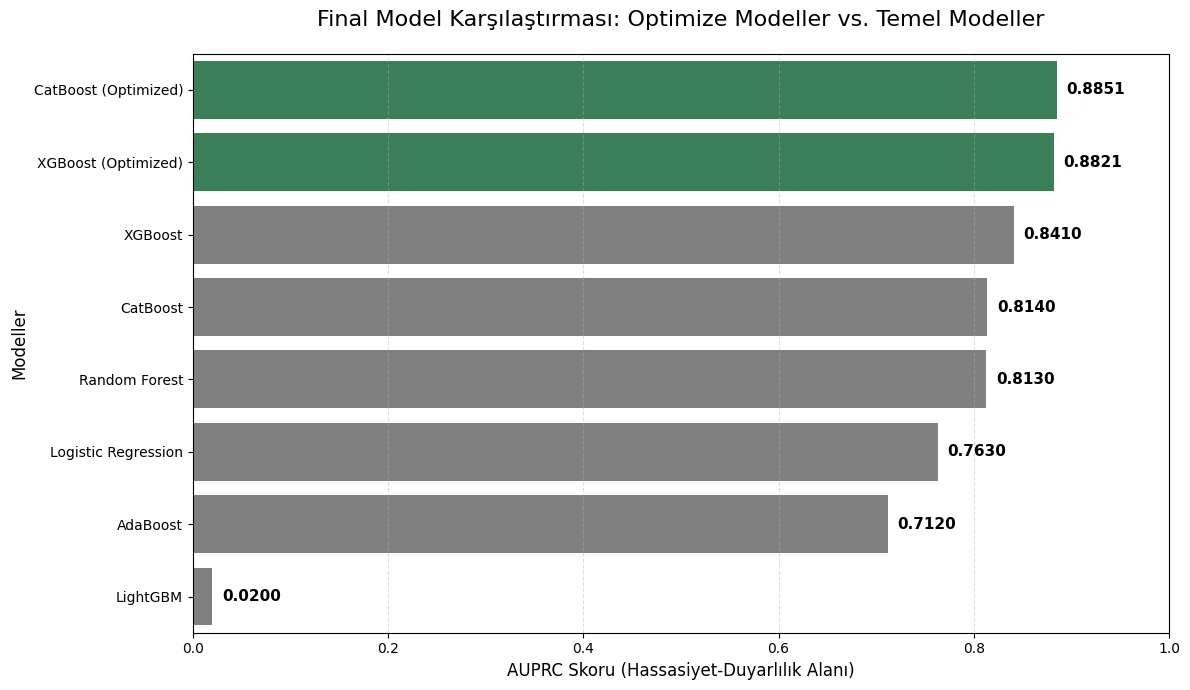

In [45]:
data = {
    'Model': ['XGBoost', 'CatBoost', 'Random Forest', 'Logistic Regression', 'AdaBoost', 'LightGBM'],
    'AUPRC': [0.841, 0.814, 0.813, 0.763, 0.712, 0.020]
}
df_final = pd.DataFrame(data)

# 2. Senin optimize edilmiş yeni skorlarını ekleyelim
optimized_data = pd.DataFrame({
    'Model': ['XGBoost (Optimized)', 'CatBoost (Optimized)'],
    'AUPRC': [0.8821, 0.8851]
})

# Verileri birleştir ve başarı sırasına göre sırala
df_plot = pd.concat([df_final, optimized_data], ignore_index=True)
df_plot = df_plot.sort_values(by='AUPRC', ascending=False)

# 3. Görselleştirme
plt.figure(figsize=(12, 7))
# En iyi iki modeli vurgulamak için renk paleti ayarlayalım
colors = ['#2E8B57' if 'Optimized' in m else '#808080' for m in df_plot['Model']]

ax = sns.barplot(data=df_plot, x='AUPRC', y='Model', palette=colors)

# Skorları çubukların üzerine yazdıralım
for i in ax.containers:
    ax.bar_label(i, fmt='%.4f', padding=7, fontsize=11, fontweight='bold')

plt.title('Final Model Karşılaştırması: Optimize Modeller vs. Temel Modeller', fontsize=16, pad=20)
plt.xlabel('AUPRC Skoru (Hassasiyet-Duyarlılık Alanı)', fontsize=12)
plt.ylabel('Modeller', fontsize=12)
plt.xlim(0, 1.0) # Tam skalayı görmek için
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

Çalışmanın sonucunda, şu çıktıyı elde ettik;

Optimize Boosting algoritmaları
Optimize olmayan Boosting algoritmaları
Bagging algoritmaları
Lojistik regresyon

yüksek oranla bu sırada başarı sırası elde etiik. Bizim Fraud Detection problemimizin çözümünde en efektif algoritmalar sırası ile bunlardır.
LightGBM algoritmasının diğerlerine nazaran çok daha düşük bir performans sergilemesinin temel sebebi kaybı en çok azaltan yapraktan devam etmesidir.
(Diğerleri çok iyi sonuçlar veriyor, mucizevi bir şey beklemediğim için parametre değiştirmeden diğerlerinden daha iyi sonuçlar almayı tercih ettim)

c:\Users\furka\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:24:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\furka\AppData\Local\Temp\ipykernel_15752\785135557.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=fi_df.head(15), palette='plasma')


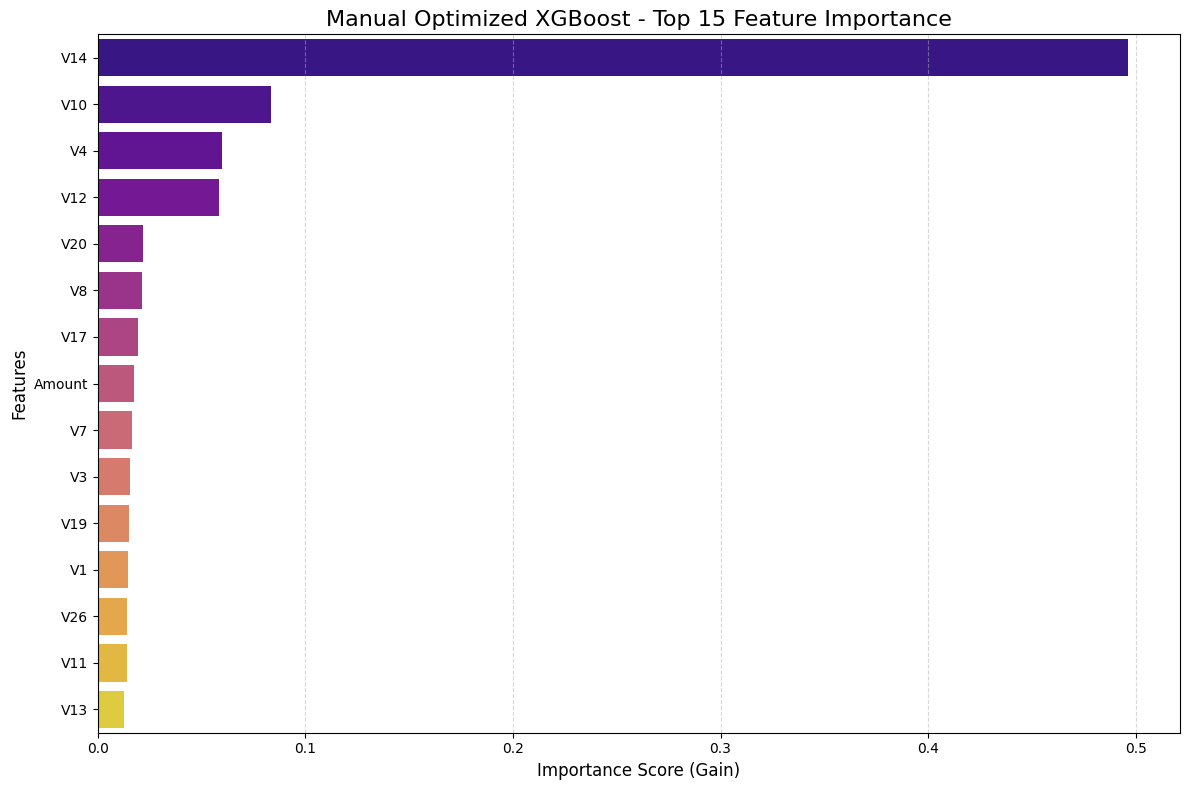

In [46]:
manual_params = {
    'n_estimators': 900,
    'max_depth': 6,
    'learning_rate': 0.050027836735222424,
    'subsample': 0.8961779747189235,
    'colsample_bytree': 0.9343832076488651,
    'min_child_weight': 6,
    'random_state': 42,
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}

# 2. Pipeline Kurulumu ve Eğitim
# Not: scale_weight değerinin daha önceden hesaplandığını varsayıyoruz
manual_xgb_pipe = Pipeline([
    ('yeo', PowerTransformer(method='yeo-johnson')),
    ('scaler', RobustScaler()),
    ('classifier', XGBClassifier(**manual_params, scale_pos_weight=scale_weight))
])

manual_xgb_pipe.fit(X_train, y_train)

# 3. Özellik Önem Skorlarının Alınması
xgb_model = manual_xgb_pipe.named_steps['classifier']
fi_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# 4. Görselleştirme
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=fi_df.head(15), palette='plasma')

plt.title('Manual Optimized XGBoost - Top 15 Feature Importance', fontsize=16)
plt.xlabel('Importance Score (Gain)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

XGBoost için V14 değişkeninin diğerlerine nazaran katbekat daha öenmli olması, XGBoost algoritmasının o değişkenden elde ettiği maksimum gain'in çok daha yüksek olmasıdır.